# Optmiziation of Deep Learning for Cardiologist-level Myocardial Infarction Detection in Electrocardiograms

In [1]:
## Many neural networks we tested: AlexNet, ResNet50, Gradient Boosting CNN, ConvNetQuake
## the best one so far is the ConvQuakeNet

##start by processing the data
##then create the nn.Model subclass
##then call the Pso(forward function of model)
##then return loss score; ie optimize hyperparameters for search convergence

In [26]:
##extract data in dataframes, use 2 channels, v6: anterior lead, vz: left wrist lead
##two most prominent in myocardial infarction diagnosis
## no cleaning required, data is clean
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.switch_backend('agg')
import wfdb
import time
import random
from sklearn.preprocessing import minmax_scale
import sys
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix,roc_curve, auc
#pip install PyQt6
##alternative to ensure matplotlib('agg') backend
%matplotlib inline  

In [3]:
#!pip install torch_pso

In [3]:
from torch.nn import Sequential, Linear, MSELoss
from torch_pso import ParticleSwarmOptimizer

In [4]:
torch.cuda.is_available()

False

In [5]:
torch.__version__

'2.3.0+cpu'

In [ ]:
#pip install numpy --pre torch torchvision torchaudio --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu117

In [6]:
torch.cuda.is_available()

False

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD  ##use the 2 apis PyTorch and KerasCV, KerasCV is easier

# _______________END OF ptb_data_prepare.py_____________________

In [8]:
%run ptb_data_prepare.ipynb

In [9]:
##keras sequential model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import copy

In [96]:
class ConvNetQuake(nn.Module):##issues with keras attributes, use PyTorch
    def __init__(self):
        super(ConvNetQuake, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv6 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv8 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.linear1 = nn.Linear(1280, 128)
        #self.linear1 = nn.Linear(4096, 10)
        self.linear2 = nn.Linear(128, 1)
        #self.linear2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(32)
        self.bn5 = nn.BatchNorm1d(32)
        self.bn6 = nn.BatchNorm1d(32)
        self.bn7 = nn.BatchNorm1d(32)
        self.bn8 = nn.BatchNorm1d(32)
        '''self.conv1 = keras.layers.Conv1D(kernel_size=3, stride=2, padding=1, data_format=(batch, features, steps))(x)
        self.dense2 = keras.layers.Dense(5, activation="softmax")
        self.dropout = keras.layers.Dropout(0.5)'''

    def forward(self, x):  ##x is preliminary input
        x = self.bn1(F.relu((self.conv1(x))))
        x = self.bn2(F.relu((self.conv2(x))))
        x = self.bn3(F.relu((self.conv3(x))))
        x = self.bn4(F.relu((self.conv4(x))))
        x = self.bn5(F.relu((self.conv5(x))))
        x = self.bn6(F.relu((self.conv6(x))))
        x = self.bn7(F.relu((self.conv7(x))))
        x = self.bn8(F.relu((self.conv8(x))))
        #x = torch.reshape(x, (10, -1))
        x = torch.reshape(x, (16, -1))
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        '''x = self.dense1(inputs)
        x = self.dropout(x, training=training)
        return self.dense2(x)'''
        return x

In [97]:
model = ConvNetQuake()
#model.cuda() ##compute engine device

model = nn.DataParallel(model, device_ids=[0])

In [98]:
batchnorm_layers = [model.module.bn1, model.module.bn2, model.module.bn3, model.module.bn4
                   , model.module.bn5, model.module.bn6, model.module.bn7, model.module.bn8]

In [99]:
for batch_norm_layer in batchnorm_layers:
    batch_norm_layer.running_mean = nn.Parameter(torch.full_like(batch_norm_layer.running_mean, 27.0))
    batch_norm_layer.running_mean.requires_grad = False

In [100]:
batchnorm_layers[0]

BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

#### TRIAL ONE OF TRAINING, WITHOUT CONFUSION MATRIX AND ROC

In [31]:
#model = ConvNetQuake()
#model.cuda() ##compute engine device

#model = nn.DataParallel(model, device_ids=[0])
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
pso_optimizer = ParticleSwarmOptimizer(model.parameters(),
                               inertial_weight=0.5,
                               num_particles=100,
                               max_param_value=1,
                               min_param_value=-1)
criterion = nn.BCELoss()
##run the model now
num_iters = 5000
batch_size = 16

acc_values = []
acc_values_train = []
avg_loss = []
#val_loss = []
for iters in range(num_iters):
    batch_x, batch_y = get_batch(batch_size, split='train')
    y_pred = model(batch_x)
    
    def closure():
        # Clear any grads from before the optimization step, since we will be changing the parameters
        optimizer.zero_grad()  
        return criterion(y_pred, batch_y)
    
    loss = criterion(y_pred, batch_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step(closure)
    
    # validation
    if iters%100 == 0 and iters != 0:

        print('Loss/train', loss, iters)
        avg_loss.append(loss)
        with torch.no_grad():

            # test_set
            iterations = 100
            avg_acc = 0

            for _ in range(iterations):
                batch_x, batch_y = get_batch(batch_size, split='val')
                cleaned = model(batch_x)

                count = 0
                acc = 0
                for num in cleaned:
                    if int(torch.round(num)) == int(torch.round(batch_y[count])):
                        acc += 10
                    count += 1
                avg_acc += acc

            acc_values.append((avg_acc / iterations))
            print('Accuracy/val', (avg_acc / iterations), iters)

            # train_set
            iterations = 100
            avg_acc = 0

            for _ in range(iterations):
                batch_x, batch_y = get_batch(batch_size, split='train')
                cleaned = model(batch_x)

                count = 0
                acc = 0
                for num in cleaned:
                    if int(torch.round(num)) == int(torch.round(batch_y[count])):
                        acc += 10
                    count += 1
                avg_acc += acc

            
            acc_values_train.append((avg_acc / iterations))
            print('Accuracy/train', (avg_acc / iterations), iters)

Loss/train tensor(0.7084, grad_fn=<BinaryCrossEntropyBackward0>) 100
Accuracy/val 66.9 100
Accuracy/train 72.0 100
Loss/train tensor(0.7615, grad_fn=<BinaryCrossEntropyBackward0>) 200
Accuracy/val 67.0 200
Accuracy/train 73.2 200
Loss/train tensor(0.7655, grad_fn=<BinaryCrossEntropyBackward0>) 300
Accuracy/val 72.0 300
Accuracy/train 70.9 300
Loss/train tensor(0.6920, grad_fn=<BinaryCrossEntropyBackward0>) 400
Accuracy/val 70.8 400
Accuracy/train 72.3 400
Loss/train tensor(0.6735, grad_fn=<BinaryCrossEntropyBackward0>) 500
Accuracy/val 70.1 500
Accuracy/train 73.5 500
Loss/train tensor(0.6922, grad_fn=<BinaryCrossEntropyBackward0>) 600
Accuracy/val 73.6 600
Accuracy/train 71.3 600
Loss/train tensor(0.6982, grad_fn=<BinaryCrossEntropyBackward0>) 700
Accuracy/val 66.5 700
Accuracy/train 71.9 700
Loss/train tensor(0.7117, grad_fn=<BinaryCrossEntropyBackward0>) 800
Accuracy/val 70.4 800
Accuracy/train 72.0 800
Loss/train tensor(0.6849, grad_fn=<BinaryCrossEntropyBackward0>) 900
Accuracy/va

In [93]:
model.parameters

<bound method Module.parameters of DataParallel(
  (module): ConvNetQuake(
    (conv1): Conv1d(3, 27, kernel_size=(3,), stride=(2,), padding=(1,))
    (conv2): Conv1d(27, 27, kernel_size=(3,), stride=(2,), padding=(1,))
    (conv3): Conv1d(27, 27, kernel_size=(3,), stride=(2,), padding=(1,))
    (conv4): Conv1d(27, 27, kernel_size=(3,), stride=(2,), padding=(1,))
    (conv5): Conv1d(27, 27, kernel_size=(3,), stride=(2,), padding=(1,))
    (conv6): Conv1d(27, 27, kernel_size=(3,), stride=(2,), padding=(1,))
    (conv7): Conv1d(27, 27, kernel_size=(3,), stride=(2,), padding=(1,))
    (conv8): Conv1d(27, 27, kernel_size=(3,), stride=(2,), padding=(1,))
    (linear1): Linear(in_features=1280, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=1, bias=True)
    (sigmoid): Sigmoid()
    (bn1): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


#### TRIAL TWO OF TRAINING, WITH CONFUSION MATRIX AND ROC

In [101]:
##TO RUN 
#model = ConvNetQuake()
#model = nn.DataParallel(model, device_ids=[0])

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
pso_optimizer = ParticleSwarmOptimizer(model.parameters(),
                               inertial_weight=0.5,
                               num_particles=100,
                               max_param_value=1,
                               min_param_value=-1)
criterion = nn.BCELoss()

##run the model now
num_iters = 5000
batch_size = 16

acc_values = []
acc_values_train = []
avg_loss = []

true_labels = []
predicted_scores = []
for iters in range(num_iters):
    batch_x, batch_y = get_batch(batch_size, split='train')
    y_pred = model(batch_x)
    
    def closure():
        # Clear any grads from before the optimization step, since we will be changing the parameters
        optimizer.zero_grad()  
        return criterion(y_pred, batch_y)
    
    loss = criterion(y_pred, batch_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step(closure)
    
    # Validation
    if iters%100 == 0 and iters != 0:
        print('Loss/train', loss, iters)
        avg_loss.append(loss)
        
        with torch.no_grad():

            # test_set
            iterations = 100
            val_true_labels = []
            val_predicted_scores = []
            avg_acc = 0

            for _ in range(iterations):
                batch_x, batch_y = get_batch(batch_size, split='val')
                cleaned = model(batch_x)

                count = 0
                acc = 0
                for  num, true_label in zip(cleaned, batch_y):
                    if int(torch.round(num)) == int(torch.round(batch_y[count])):
                        acc += 10
                    count += 1
                    val_true_labels.append(int(torch.round(true_label)))
                    val_predicted_scores.append(float(num))
                avg_acc += acc

            acc_values.append((avg_acc / iterations))
            print('Accuracy/val', (avg_acc / iterations), iters)
            
            ##accumulate true labels and predicted scores
                #for num, true_label in zip(cleaned, batch_y):
                #    val_true_labels.append(int(torch.round(true_label)))
                #    val_predicted_scores.append(float(num))

            true_labels.extend(val_true_labels)
            predicted_scores.extend(val_predicted_scores)
            
            # train_set
            iterations = 100
            avg_acc = 0

            for _ in range(iterations):
                batch_x, batch_y = get_batch(batch_size, split='train')
                cleaned = model(batch_x)

                count = 0
                acc = 0
                for num in cleaned:
                    if int(torch.round(num)) == int(torch.round(batch_y[count])):
                        acc += 10
                    count += 1
                avg_acc += acc

            
            acc_values_train.append((avg_acc / iterations))
            print('Accuracy/train', (avg_acc / iterations), iters)

##convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_scores = np.array(predicted_scores)

##confusion matrix
cm = confusion_matrix(true_labels, np.round(predicted_scores))
print("Confusion Matrix:")
print(cm)


Loss/train tensor(0.7074, grad_fn=<BinaryCrossEntropyBackward0>) 100


KeyboardInterrupt: 

AUC: 0.49857877186588917


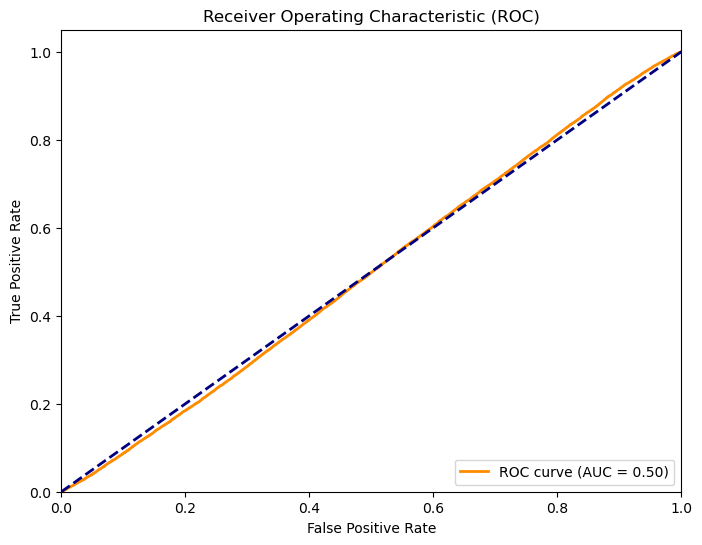

In [24]:
##ROC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

#plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

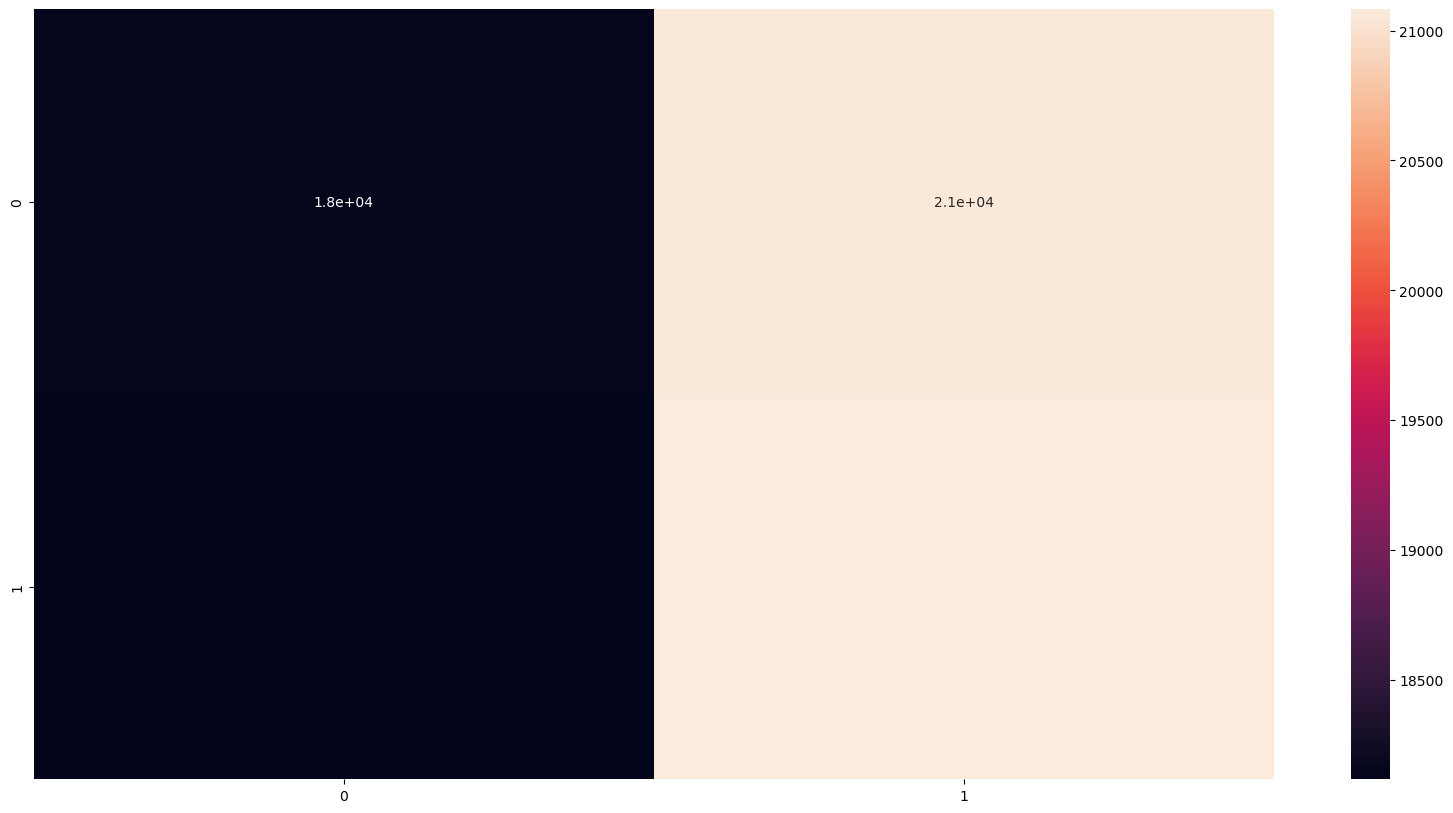

In [27]:
convnet_df_cm = pd.DataFrame(cm)
plt.figure(figsize = (20,10))
#sns.set(font_scale=1.4) #for label size
sns.heatmap(convnet_df_cm, annot=True)#, annot_kws={"size": 12}) #font size
plt.show()

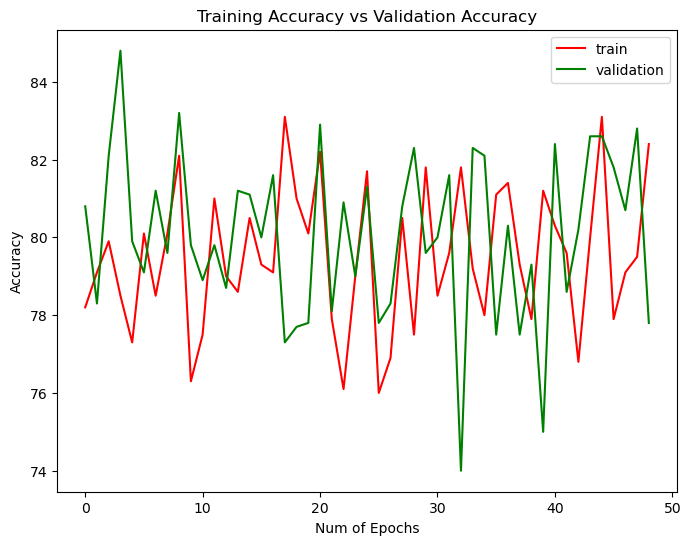

In [28]:
plt.figure(0)
plt.plot(acc_values_train,'r')
plt.plot(acc_values,'g')
#plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

#plt.show()

In [29]:
model_loss = []
for i in range(len(avg_loss)):
    model_loss.append(avg_loss[i].detach().tolist())

Text(0.5, 1.0, 'Gradient Optimizer Loss')

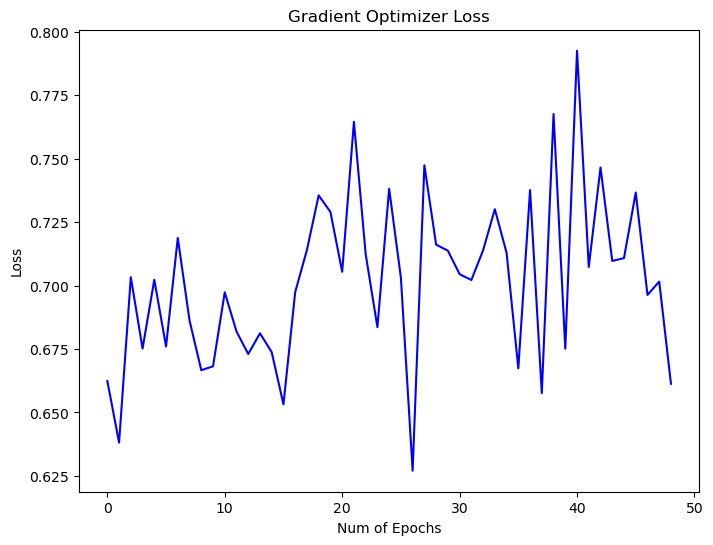

In [30]:
plt.plot(model_loss,'b')
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Gradient Optimizer Loss")

In [31]:
#model.save('./models/convnet-pso_multiple_channel.keras')
torch.save(model.state_dict(), './models/convnet-pso_multi_state.pth')
torch.save(model, './models/convnet-pso_multi_arch.pth')

## ___________________REFERENCES____________________________________________________

In [ ]:
'''net = Sequential(Linear(10,100), Linear(100,100), Linear(100,10))
optim = ParticleSwarmOptimizer(net.parameters(),
                               inertial_weight=0.5,
                               num_particles=100,
                               max_param_value=1,
                               min_param_value=-1)
criterion = MSELoss()
target = torch.rand((10,)).round()

x = torch.rand((10,))
for _ in range(100):
    
    def closure():
        # Clear any grads from before the optimization step, since we will be changing the parameters
        optim.zero_grad()  
        return criterion(net(x), target)
    
    optim.step(closure)
    print('Prediciton', net(x))
    print('Target    ', target)'''

In [145]:
##PSO Classes
##Particle object class
class Particle(object):
    '''Particle class for PSO: each search member is a particle'''

    '''Arguments:
        lower_bound (np.array): Vector of lower boundaries for particle dimensions.
        upper_bound (np.array): Vector of upper boundaries for particle dimensions.
        dimensions (int): Number of dimensions of the search space.
        objective function (function): Black-box function to evaluate.
'''
    def __init__(self, lower_bound, upper_bound, dimensions, objective_function):
        self.reset(dimensions, lower_bound, upper_bound, objective_function)

    def reset(self, dimensions, lower_bound, upper_bound, objective_function):
        '''Particle reset: allows for reset of a particle without reallocation'''
        position = []
        for i in range(dimensions):
            if lower_bound[i] < upper_bound[i]:
                position.extend(np.random.randint(lower_bound[i], upper_bound[i] + 1, 1, dtype=int))
            elif lower_bound[i] == upper_bound[i]:
                position.extend(np.array([lower_bound[i]], dtype=int))
            else:
                assert False

        self.position = [position]

        self.velocity = [np.multiply(np.random.rand(dimensions),
                                     (upper_bound - lower_bound)).astype(int)]

        self.best_position = self.position[:]

        self.function_value = [objective_function(self.best_position[-1])]
        self.best_function_value = self.function_value[:]
    
    def update_velocity(self, omega, phip, phig, best_swarm_position):
        '''Particle velocity update'''

        '''Args:
            omega (float): Velocity equation constant.
            phip (float): Velocity equation constant.
            phig (float): Velocity equation constant.
            best_swarm_position (np.array): Best global particle position.'''

        random_coefficient_p = np.random.uniform(size=np.asarray(self.position[-1]).shape)
        random_coefficient_g = np.random.uniform(size=np.asarray(self.position[-1]).shape)

        self.velocity.append(omega*np.asarray(self.velocity[-1])
                             + (phip*random_coefficient_p
                                * (np.asarray(self.best_position[-1])- np.asarray(self.position[-1])))
                             + (phig* random_coefficient_g
                             * (np.asarray(best_swarm_position)- np.asarray(self.position[-1]))))

        self.velocity[-1] = self.velocity[-1].astype(int)

    def update_position(self, lower_bound, upper_bound, objective_function):
        '''Particle position update, current position + Vd+1'''
                             
        new_position = self.position[-1] + self.velocity[-1]

        if np.array_equal(self.position[-1], new_position):
            self.function_value.append(self.function_value[-1])
        else:
            mark1 = new_position < lower_bound
            mark2 = new_position > upper_bound

            new_position[mark1] = lower_bound[mark1]
            new_position[mark2] = upper_bound[mark2]

            self.function_value.append(objective_function(self.position[-1]))

        self.position.append(new_position.tolist())

        if self.function_value[-1] < self.best_function_value[-1]:
            self.best_position.append(self.position[-1][:])
            self.best_function_value.append(self.function_value[-1])

In [146]:
class Pso(object):
    '''PSO wrapper

    This class contains the particles and provides an abstraction to hold all the context
    of the PSO algorithm

    Args:
        swarmsize (int): Number of particles in the swarm
        maxiter (int): Maximum number of generations the swarm will run'''

    
    def __init__(self, swarmsize=100, maxiter=100):
        self.max_generations = maxiter
        self.swarmsize = swarmsize

        self.omega = 0.5  ##start c1 and c2 at 0.5, balance exploration and exploitation
        self.phip = 0.5
        self.phig = 0.5

        self.minstep = 1e-4
        self.minfunc = 1e-4

        self.best_position = [None]
        self.best_function_value = [1]

        self.particles = []

        self.retired_particles = []

    def run(self, function, lower_bound, upper_bound, kwargs=None):
        '''Perform a particle swarm optimization (PSO)'''

        '''Args:
            objective_function (function): The function to be minimized.
            lower_bound (np.array): Vector of lower boundaries for particle dimensions.
            upper_bound (np.array): Vector of upper boundaries for particle dimensions.

        Returns:
            best_position (np.array): Best known position
            accuracy (float): Objective value at best_position
            :param kwargs:'''

        
        if kwargs is None:
            kwargs = {}

        objective_function = lambda x: function(x, **kwargs)
        assert hasattr(function, '__call__'), 'Invalid function handle'

        assert len(lower_bound) == len(upper_bound), 'Invalid bounds length'

        lower_bound = np.array(lower_bound)
        upper_bound = np.array(upper_bound)

        assert np.all(upper_bound > lower_bound), 'Invalid boundary values'


        dimensions = len(lower_bound)

        self.particles = self.initialize_particles(lower_bound,
                                                   upper_bound,
                                                   dimensions,
                                                   objective_function)

        #Start evolution
        generation = 1
        while generation <= self.max_generations:
            for particle in self.particles:
                particle.update_velocity(self.omega, self.phip, self.phig, self.best_position[-1])
                particle.update_position(lower_bound, upper_bound, objective_function)

                if particle.best_function_value[-1] == 0:
                    self.retired_particles.append(copy.deepcopy(particle))
                    particle.reset(dimensions, lower_bound, upper_bound, objective_function)
                elif particle.best_function_value[-1] < self.best_function_value[-1]:
                    stepsize = np.sqrt(np.sum((np.asarray(self.best_position[-1])
                                               - np.asarray(particle.position[-1])) ** 2))

                    if np.abs(np.asarray(self.best_function_value[-1])
                              - np.asarray(particle.best_function_value[-1])) \
                            <= self.minfunc:
                        return particle.best_position[-1], particle.best_function_value[-1]
                    elif stepsize <= self.minstep:
                        return particle.best_position[-1], particle.best_function_value[-1]
                    else:
                        self.best_function_value.append(particle.best_function_value[-1])
                        self.best_position.append(particle.best_position[-1][:])



            generation += 1

        return self.best_position[-1], self.best_function_value[-1]

    def initialize_particles(self, lower_bound, upper_bound, dimensions, objective_function):
        '''Initializes the particles for the swarm'''

        '''Args:
            objective_function (function): The function to be minimized.
            lower_bound (np.array): Vector of lower boundaries for particle dimensions.
            upper_bound (np.array): Vector of upper boundaries for particle dimensions.
            dimensions (int): Number of dimensions of the search space.

        Returns:
            particles (list): Collection or particles in the swarm'''
        
        particles = []
        for _ in range(self.swarmsize):
            particles.append(Particle(lower_bound,
                                      upper_bound,
                                      dimensions,
                                      objective_function))
            if particles[-1].best_function_value[-1] < self.best_function_value[-1]:
                self.best_function_value.append(particles[-1].best_function_value[-1])
                self.best_position.append(particles[-1].best_position[-1])


        self.best_position = [self.best_position[-1]]
        self.best_function_value = [self.best_function_value[-1]]

        return particles

In [147]:
##running model with optimization function
##1) define forward function
##2) call Pso with swarmsize = input shape of input attribute of forward function in model

'''model = ConvNetQuake()
#model.cuda() ##compute engine device

model = nn.DataParallel(model, device_ids=[0])

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
criterion = nn.BCELoss()'''

In [1]:
#pip install torch-pso  ##check with built in torch pso

In [ ]:
'''num_iters = 50000
batch_size = 10

acc_values = []
acc_values_train = []

for iters in range(num_iters):

    batch_x, batch_y = get_batch(batch_size, split='train')  ##get train and test batches
    ###initialize PSO with forward input
    pso = Pso(swarmsize=batch_size,maxiter=num_iters)
    y_pred = model(batch_x)
    bp,value = pso.run(model(batch_x),[1,2,2,2],[16,8,4,4]) ##run model and get optimized outputs
    loss = criterion(y_pred, batch_y)
    ##bp === is loss
    ##value , v === is accuracy
    v = model(bp)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ###
    #y_pred = model(batch_x) ##run model on input of healthy and unhealthy patients
    #loss = criterion(y_pred, batch_y)
    #optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()
    # validation
    if iters%100 == 0 and iters != 0:

        print('Loss/train', loss, iters)
        print('PSO Loss/train', bp, iters)
        #writer.add_scalar('Loss/train', loss, iters)

        with torch.no_grad():

            # test_set
            iterations = 100
            avg_acc = 0

            for _ in range(iterations):
                batch_x, batch_y = get_batch(batch_size, split='val')
                cleaned = model(batch_x)

                count = 0
                acc = 0
                for num in cleaned:
                    if int(round(num)) == int(round(batch_y[count])):
                        acc += 10
                    count += 1
                avg_acc += acc

            acc_values.append((avg_acc / iterations))
            print('Accuracy/val', (avg_acc / iterations), iters)
            #writer.add_scalar('Accuracy/val', (avg_acc / iterations), iters)

            # train_set
            iterations = 100
            avg_acc = 0

            for _ in range(iterations):
                batch_x, batch_y = get_batch(batch_size, split='train')
                cleaned = model(batch_x)

                count = 0
                acc = 0
                for num in cleaned:
                    if int(round(num)) == int(round(batch_y[count])):
                        acc += 10
                    count += 1
                avg_acc += acc

            acc_values_train.append((avg_acc / iterations))
            #writer.add_scalar('Accuracy/train', (avg_acc / iterations), iters)
            print('Accuracy/train', (avg_acc / iterations), iters)'''

In [ ]:
'''def func(x):
  n,sf,sp,l = x[0],x[1],x[2],x[3]
 
  model = Sequential()
  model.add(Conv2D(32,kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(n, (sf, sf), activation='relu'))
  model.add(MaxPooling2D(pool_size=(sp, sp),strides=(l,l)))
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
  
  cp = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')];

  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(x_test, y_test),callbacks=cp)
  
  score = model.evaluate(x_test, y_test, verbose=0)

  # loss, val
  print('current config:',x,'val:',score[1])
  return score[1]

##################################################################
pso = Pso(swarmsize=4,maxiter=14)
# n,sf,sp,l
bp,value = pso.run(func,[1,2,2,2],[16,8,4,4])

v = func(bp);

##################################################################

print('Test loss:', bp)
print('Test accuracy:', value,v)'''

In [ ]:
#model = MyModel()